# Analytical solutions to pressure fields

In [1]:
import numpy as np

def p_tilde_sommerfeld(theta, eps):
    H = 1 + eps*np.cos(theta)
    q = np.sqrt((1 - eps)/(1 + eps))
    C1 = -6*(1 - eps**2)/(1 + 1.5*eps**2)

    # F2
    F2 = np.sin(theta)/((1 - eps**2)*H) + (2*eps/(1 - eps**2)**1.5)*np.arctan(q*np.tan(theta/2))
    # F3
    F3 = (np.sin(theta)*(2 + eps*np.cos(theta)))/(2*(1 - eps**2)*H**2) + \
         (3*eps/(2*(1 - eps**2)**2.5))*np.arctan(q*np.tan(theta/2))

    ptilde = 6*F2 + C1*F3
    # subtract value at a reference angle to set constant (e.g., theta=0)
    return ptilde - ptilde[0]

def pressure(theta, R, c, U, mu, eps):
    return (mu*U*R/c**2)*p_tilde_sommerfeld(theta, eps)

In [2]:
def p_short(theta, z, R, L, c, U, mu, eps):
    H = 1 + eps*np.cos(theta)
    return - (3*mu*U*eps/(R*c**2)) * (np.sin(theta)/H**3) * (L**2/4 - z**2)

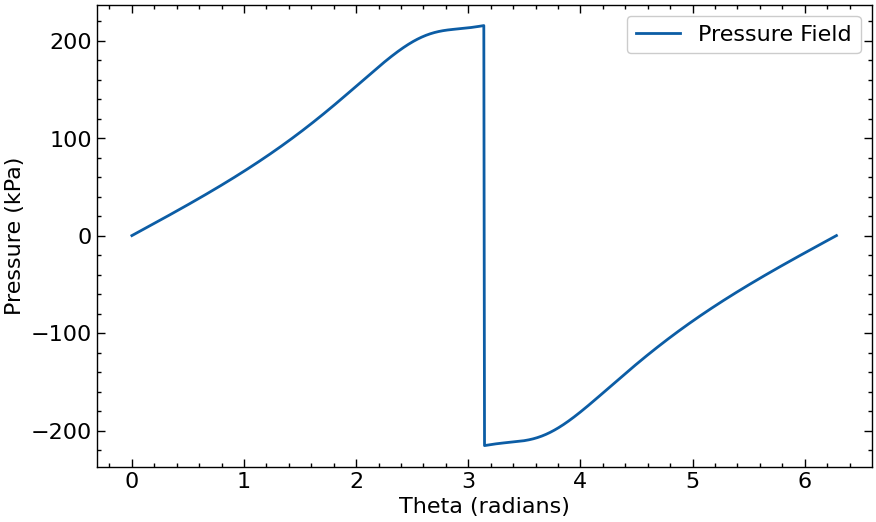

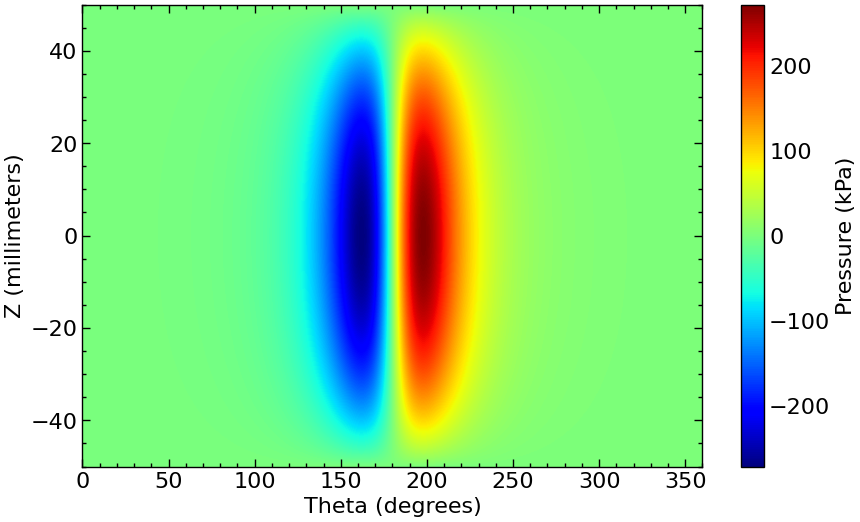

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Define parameters in millimeters
R = 50  # Radius in millimeters
c = 1  # Radial clearance in millimeters
U = 10  # Surface velocity in m/s
mu = 0.01  # Viscosity in Pa.s
eps = 0.8  # Eccentricity ratio
L = 100  # Length of the bearing in millimeters

# Generate theta and z values
theta = np.linspace(0, 2 * np.pi, 1000)
z = np.linspace(-L / 2, L / 2, 500)
Theta, Z = np.meshgrid(theta, z)

# Calculate pressure fields (convert to kPa)
P_pressure = pressure(theta, R / 1000, c / 1000, U, mu, eps) / 1e3  # Convert to meters and kPa
P_short = p_short(Theta, Z / 1000, R / 1000, L / 1000, c / 1000, U, mu, eps) / 1e3  # Convert to meters and kPa

# Plot pressure field for "pressure" function
plt.figure(figsize=(10, 6))
plt.plot(theta, P_pressure, label='Pressure Field')
plt.xlabel('Theta (radians)')
plt.ylabel('Pressure (kPa)')
plt.legend()
plt.grid()
plt.savefig('pressure_field_theta.png')  # Save the figure


# Plot pressure field for "p_short" function using imshow
plt.figure(figsize=(10, 6))
plt.imshow(P_short, extent=[0, 360, -L / 2, L / 2], aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Pressure (kPa)')
plt.xlabel('Theta (degrees)')
plt.ylabel('Z (millimeters)')
plt.grid(False)
plt.savefig('pressure_field_short.png')  # Save the figure
# plt.title('Pressure Field for short journal bearing')

plt.show()

In [8]:
from dataclasses import dataclass

@dataclass
class BearingParams:
    R: float        # journal radius [m]
    c: float        # radial clearance [m]
    mu: float       # viscosity [Pa·s]
    omega: float    # angular speed [rad/s]
    p_a: float      # ambient/supply pressure [Pa]
    eps: float      # eccentricity ratio ε in [0, 1)

def H(theta, eps):
    # nondimensional film thickness
    return 1.0 + eps * np.cos(theta)

def solve_pressure_long_gas(params: BearingParams, npts=2000, tol=1e-10, maxit=50):
    """
    Solve the 1D compressible Reynolds equation for a long journal bearing:
      d/dθ [ H^3 d(P^2)/dθ ] = Λ d(HP)/dθ
    with Y = P^2 and shooting for constant C such that P(0)=P(2π)=1.
    """
    R, c, mu, omega, p_a, eps = params.R, params.c, params.mu, params.omega, params.p_a, params.eps
    # Dimensionless bearing number for gas
    Lambda = 12.0 * mu * omega * R**2 / (p_a * c**2)

    # Grid in theta
    theta = np.linspace(0.0, 2.0*np.pi, npts)
    dtheta = theta[1] - theta[0]

    # RHS of ODE: dY/dθ = [Λ H sqrt(Y) + C] / H^3
    def rhs(theta_val, Y_val, C):
        Hv = H(theta_val, eps)
        Pv = np.sqrt(max(Y_val, 0.0))
        return (Lambda * Hv * Pv + C) / (Hv**3 + 1e-300)  # small epsilon to avoid div by zero

    # RK4 integrator for one pass given C
    def integrate_for_C(C):
        Y = np.empty_like(theta)
        Y[0] = 1.0  # P(0) = 1 => Y(0)=1
        for i in range(npts-1):
            th = theta[i]
            y = Y[i]
            k1 = rhs(th, y, C)
            k2 = rhs(th + 0.5*dtheta, y + 0.5*dtheta*k1, C)
            k3 = rhs(th + 0.5*dtheta, y + 0.5*dtheta*k2, C)
            k4 = rhs(th + dtheta, y + dtheta*k3, C)
            Y[i+1] = y + (dtheta/6.0)*(k1 + 2*k2 + 2*k3 + k4)
            if Y[i+1] < 0:
                # guard against numerical undershoot due to stiffness
                Y[i+1] = 1e-16
        return Y

    # Shooting for C so that Y(2π)=1
    # Use secant iterations on F(C) = Y_end(C) - 1
    # Initial guesses for C: start near zero and a small negative
    C0, C1 = 0.0, -1.0
    Y0 = integrate_for_C(C0)
    F0 = Y0[-1] - 1.0

    Y1 = integrate_for_C(C1)
    F1 = Y1[-1] - 1.0

    it = 0
    while abs(F1) > tol and it < maxit:
        # Secant update
        if abs(F1 - F0) < 1e-20:
            # fallback small perturbation
            C1 += -1e-3 if F1 > 0 else 1e-3
            Y1 = integrate_for_C(C1)
            F1 = Y1[-1] - 1.0
            it += 1
            continue
        C2 = C1 - F1*(C1 - C0)/(F1 - F0)
        C0, F0 = C1, F1
        C1 = C2
        Y1 = integrate_for_C(C1)
        F1 = Y1[-1] - 1.0
        it += 1

    Y = Y1
    P = np.sqrt(np.maximum(Y, 0.0))
    C_found = C1

    # Dimensional pressure
    p = P * p_a

    # Load components per unit axial length (nondimensional integrals)
    # Resulting dimensional load per unit length: W = p_a * R * ∫ P(θ) [cosθ i + sinθ j] dθ
    Wx_nd = np.trapz(P * np.cos(theta), theta)
    Wy_nd = np.trapz(P * np.sin(theta), theta)
    W_per_len_x = p_a * params.R * Wx_nd
    W_per_len_y = p_a * params.R * Wy_nd
    W_per_len = np.hypot(W_per_len_x, W_per_len_y)
    attitude_angle = np.arctan2(W_per_len_y, W_per_len_x)

    out = {
        "theta": theta,
        "P": P,
        "p": p,
        "Lambda": Lambda,
        "C": C_found,
        "Wx_nd": Wx_nd,
        "Wy_nd": Wy_nd,
        "W_per_len_x": W_per_len_x,
        "W_per_len_y": W_per_len_y,
        "W_per_len": W_per_len,
        "attitude_angle_rad": attitude_angle,
        "iterations": it,
        "residual": abs(F1)
    }
    return out

Lambda = 4.26351
Shooting constant C = -11.1375
Iterations = 50, residual = 1.00e+00
W_per_len = 2222.346 N/m
Attitude angle = 0.254 rad


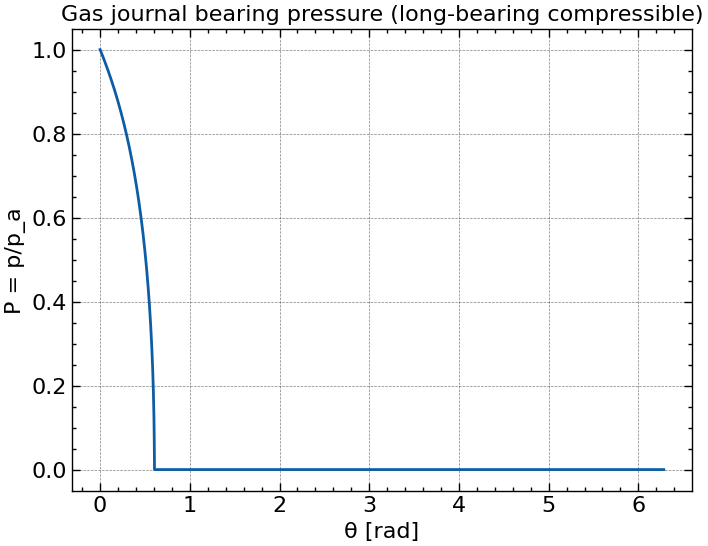

In [12]:
# Example usage
params = BearingParams(
    R=0.05,        # 50 mm
    c=50e-6,       # 50 microns
    mu=1.8e-5,     # ~air at ~20 C [Pa·s]
    omega=2000.0,  # rad/s
    p_a=101325.0,  # Pa
    eps=0.6        # moderate eccentricity
)

result = solve_pressure_long_gas(params, npts=4000, tol=1e-10)
print(f"Lambda = {result['Lambda']:.6g}")
print(f"Shooting constant C = {result['C']:.6g}")
print(f"Iterations = {result['iterations']}, residual = {result['residual']:.2e}")
print(f"W_per_len = {result['W_per_len']:.3f} N/m")
print(f"Attitude angle = {result['attitude_angle_rad']:.3f} rad")

# If you want to view the pressure distribution, you can plot with matplotlib:
try:
    import matplotlib.pyplot as plt
    th = result["theta"]
    P = result["P"]
    plt.figure()
    plt.plot(th, P)
    plt.xlabel("θ [rad]")
    plt.ylabel("P = p/p_a")
    plt.title("Gas journal bearing pressure (long-bearing compressible)")
    plt.grid(True)
    plt.show()
except Exception as e:
    pass

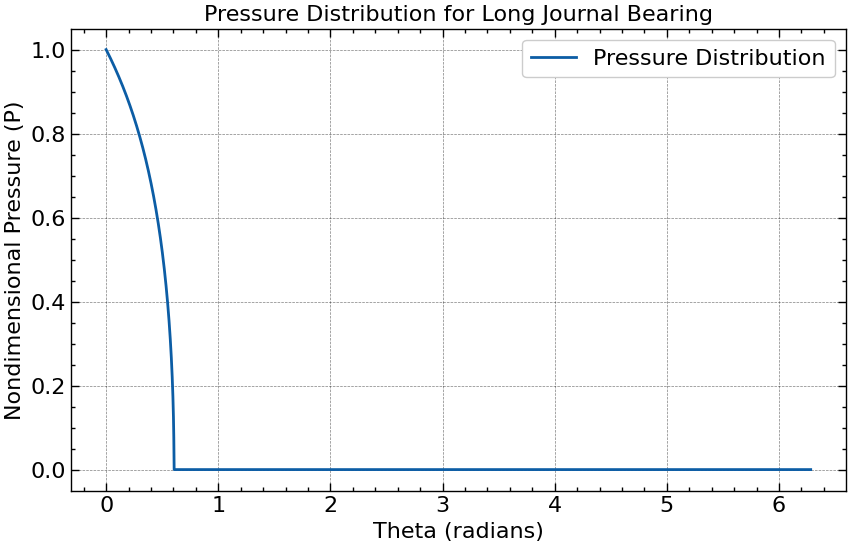

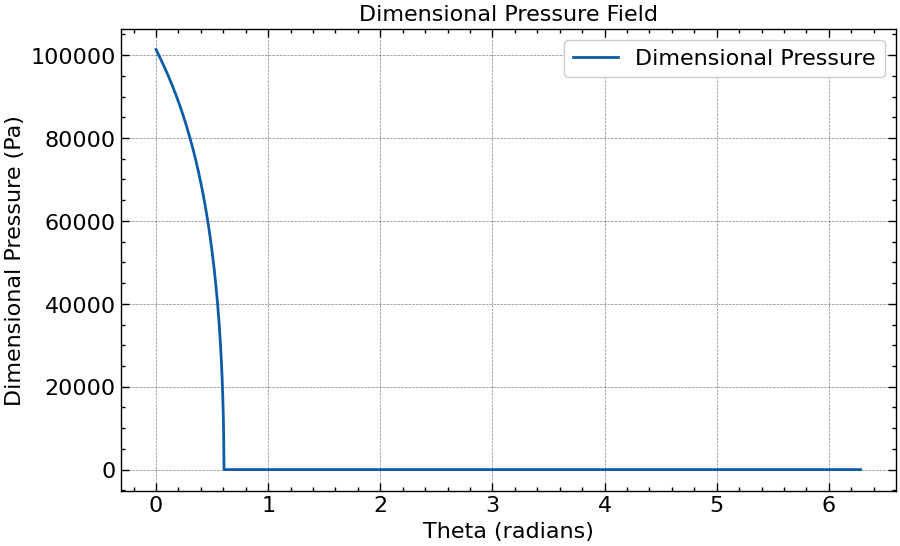

In [13]:
# Plot the pressure distribution for the long journal bearing
plt.figure(figsize=(10, 6))
plt.plot(result['theta'], result['P'], label='Pressure Distribution')
plt.xlabel('Theta (radians)')
plt.ylabel('Nondimensional Pressure (P)')
plt.title('Pressure Distribution for Long Journal Bearing')
plt.legend()
plt.grid(True)
plt.show()

# Plot the dimensional pressure field
plt.figure(figsize=(10, 6))
plt.plot(result['theta'], result['p'], label='Dimensional Pressure')
plt.xlabel('Theta (radians)')
plt.ylabel('Dimensional Pressure (Pa)')
plt.title('Dimensional Pressure Field')
plt.legend()
plt.grid(True)
plt.show()

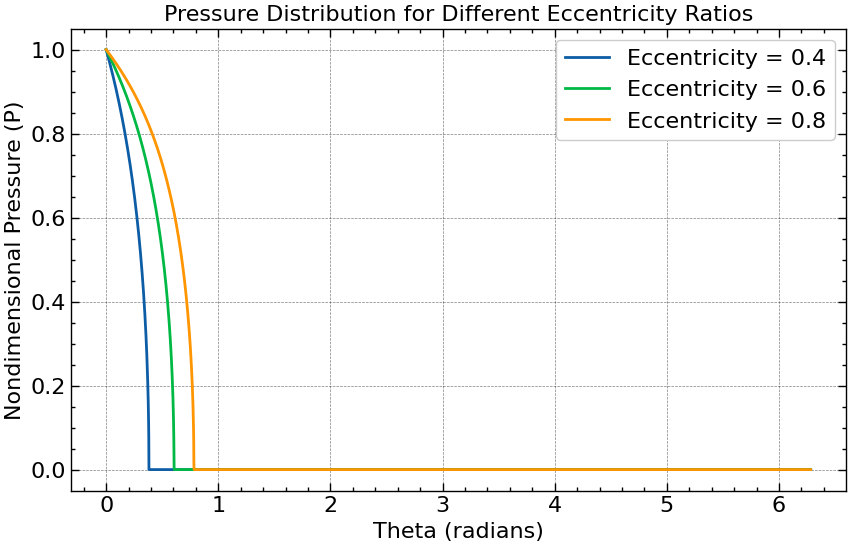

In [14]:
# Compute and plot pressure fields for different cases
cases = [
    {'eps': 0.4, 'label': 'Eccentricity = 0.4'},
    {'eps': 0.6, 'label': 'Eccentricity = 0.6'},
    {'eps': 0.8, 'label': 'Eccentricity = 0.8'}
]

plt.figure(figsize=(10, 6))

for case in cases:
    params.eps = case['eps']
    result = solve_pressure_long_gas(params, npts=4000, tol=1e-10)
    plt.plot(result['theta'], result['P'], label=case['label'])

plt.xlabel('Theta (radians)')
plt.ylabel('Nondimensional Pressure (P)')
plt.title('Pressure Distribution for Different Eccentricity Ratios')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import numpy as np
from dataclasses import dataclass

@dataclass
class BearingParams:
    R: float        # journal radius [m]
    c: float        # radial clearance [m]
    mu: float       # viscosity [Pa·s]
    omega: float    # angular speed [rad/s]
    p_a: float      # ambient/supply pressure [Pa]
    eps: float      # eccentricity ratio, 0<=eps<1
    L: float = None # bearing length [m] (needed for short-bearing)

def H(theta, eps):
    return 1.0 + eps * np.cos(theta)

def solve_pressure_short_gas(params: BearingParams,
                             ntheta=2000, nz=101,
                             tol=1e-12, maxit=50):
    """
    Short-bearing solution for isothermal compressible (gas) journal bearing.

    Governing reduction:
      Let S(θ) = H(θ) P(θ), α = Λ L^2 / (8 R^2),
      Then dS/dθ = - (H/α) [ S^2 - H^2 ], with periodicity S(0)=S(2π) (shoot for S0).
      Reconstruct full field via:
        P^2(θ,z) = 1 + (S^2/H^2 - 1) * (1 - 4 z^2 / L^2)

    Returns centerline and full field, load, and diagnostics.
    """
    if params.L is None or params.L <= 0:
        raise ValueError("Short-bearing solver needs a positive length L in params.")

    R, c, mu, omega, p_a, eps, L = params.R, params.c, params.mu, params.omega, params.p_a, params.eps, params.L

    # Dimensionless gas bearing number
    Lambda = 12.0 * mu * omega * R**2 / (p_a * c**2)
    # Short-bearing constant
    alpha = Lambda * L**2 / (8.0 * R**2)

    # Angular grid
    theta = np.linspace(0.0, 2.0*np.pi, ntheta)
    dth = theta[1] - theta[0]
    H_arr = H(theta, eps)

    # ODE: dS/dθ = -(H/alpha) (S^2 - H^2)
    def rhs(th_i, S_i):
        # H evaluated at th_i
        H_i = 1.0 + eps * np.cos(th_i)
        return -(H_i/alpha) * (S_i**2 - H_i**2)

    def integrate_S(S0):
        S = np.empty_like(theta)
        S[0] = S0
        # RK4 march over theta
        for i in range(ntheta-1):
            th = theta[i]
            s = S[i]
            k1 = rhs(th, s)
            k2 = rhs(th + 0.5*dth, s + 0.5*dth*k1)
            k3 = rhs(th + 0.5*dth, s + 0.5*dth*k2)
            k4 = rhs(th + dth,     s + dth*k3)
            S[i+1] = s + (dth/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return S

    # Shooting for periodicity: F(S0) = S(2π; S0) - S0 = 0
    # Choose two initial guesses around H(0)
    H0 = H_arr[0]
    S0a = H0 * 0.8
    S0b = H0 * 1.2
    Sa = integrate_S(S0a)
    Fa = Sa[-1] - S0a
    Sb = integrate_S(S0b)
    Fb = Sb[-1] - S0b

    it = 0
    # Secant iterations
    while abs(Fb) > tol and it < maxit:
        denom = (Fb - Fa)
        if abs(denom) < 1e-20:
            # perturb slightly to avoid stagnation
            S0b += 1e-3 * (1.0 if Fb >= 0 else -1.0)
            Sb = integrate_S(S0b)
            Fb = Sb[-1] - S0b
            it += 1
            continue
        S0c = S0b - Fb * (S0b - S0a) / denom
        S0a, Fa = S0b, Fb
        S0b = S0c
        Sb = integrate_S(S0b)
        Fb = Sb[-1] - S0b
        it += 1

    S = Sb
    # Centerline dimensionless pressure
    P_center = S / H_arr
    # Ensure positivity (gas): avoid tiny negative due to numerical error
    P_center = np.maximum(P_center, 1e-14)

    # Build axial grid and full pressure field via the parabolic form in P^2
    z = np.linspace(-L/2.0, +L/2.0, nz)
    zfac = (1.0 - 4.0 * (z[:, None]**2) / (L**2))  # shape: (nz,1) so it broadcasts with theta
    # From ODE, S^2/H^2 - 1 = - (alpha/H^3) dS/dθ, but we can use the direct form for P^2:
    amp = (P_center**2 - 1.0)  # amplitude of the parabola in P^2
    P2_full = 1.0 + zfac * amp[None, :]
    # Numerical guard
    P2_full = np.maximum(P2_full, 1e-30)
    P_full = np.sqrt(P2_full)
    p_full = P_full * p_a

    # Loads: W = ∫∫ p(θ,z) [cosθ i + sinθ j] R dθ dz
    # Use trapezoidal integration over θ and z
    cos_th = np.cos(theta)[None, :]  # shape (1, ntheta)
    sin_th = np.sin(theta)[None, :]
    Wx = p_a * R * np.trapz(np.trapz(P_full * cos_th, theta, axis=1), z)
    Wy = p_a * R * np.trapz(np.trapz(P_full * sin_th, theta, axis=1), z)
    W = np.hypot(Wx, Wy)
    attitude = np.arctan2(Wy, Wx)

    out = {
        "theta": theta,
        "z": z,
        "H": H_arr,
        "Lambda": Lambda,
        "alpha": alpha,
        "S": S,
        "P_center": P_center,
        "P_full": P_full,   # shape (nz, ntheta)
        "p_full": p_full,   # Pa
        "Wx": Wx, "Wy": Wy, "W": W, "attitude_angle_rad": attitude,
        "shoot_iterations": it,
        "shoot_residual": abs(Fb)
    }
    return out

Lambda = 4.26351, alpha = 0.0852702
Shooting: iterations = 1, residual = 0.00e+00
Total load W = 10.417 N, attitude = 1.880 rad


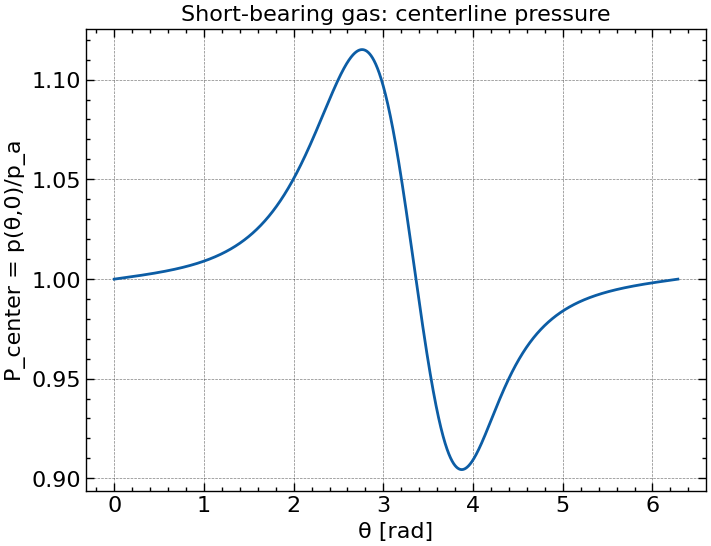

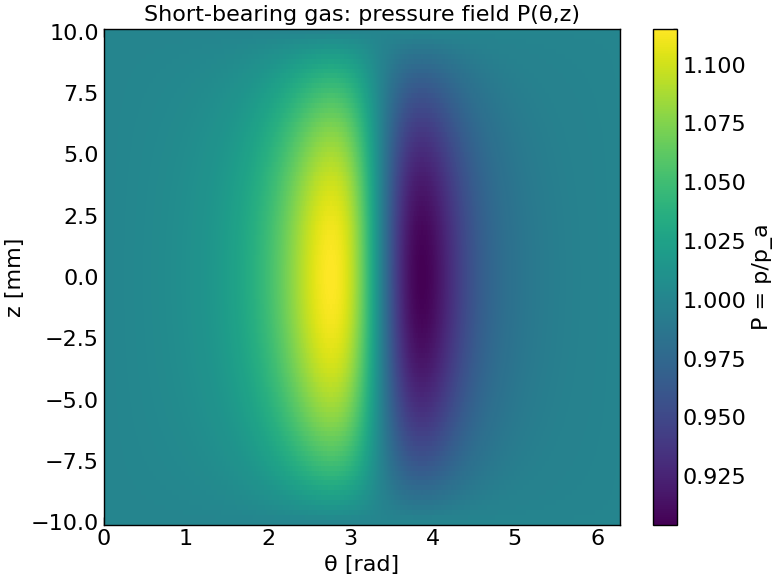

In [24]:
# Parameters typical for an air bearing
params = BearingParams(
    R=0.05,        # 50 mm
    c=50e-6,       # 50 microns
    mu=1.8e-5,     # Pa·s
    omega=2000.0,  # rad/s
    p_a=101325.0,  # Pa
    eps=0.6,       # eccentricity ratio
    L=0.02         # 20 mm bearing length (short vs 2*R=100 mm -> L/R=0.4)
)

res = solve_pressure_short_gas(params, ntheta=4096, nz=101, tol=1e-12)
print(f"Lambda = {res['Lambda']:.6g}, alpha = {res['alpha']:.6g}")
print(f"Shooting: iterations = {res['shoot_iterations']}, residual = {res['shoot_residual']:.2e}")
print(f"Total load W = {res['W']:.3f} N, attitude = {res['attitude_angle_rad']:.3f} rad")

# Optional plotting
try:
    import matplotlib.pyplot as plt
    th = res["theta"]; z = res["z"]
    Pcen = res["P_center"]
    plt.figure()
    plt.plot(th, Pcen)
    plt.xlabel("θ [rad]"); plt.ylabel("P_center = p(θ,0)/p_a")
    plt.title("Short-bearing gas: centerline pressure")
    plt.grid(True)

    # 2D map
    plt.figure()
    T, Z = np.meshgrid(th, z)
    plt.pcolormesh(T, Z*1e3, res["P_full"], shading="auto")
    plt.colorbar(label="P = p/p_a")
    plt.xlabel("θ [rad]"); plt.ylabel("z [mm]")
    plt.title("Short-bearing gas: pressure field P(θ,z)")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

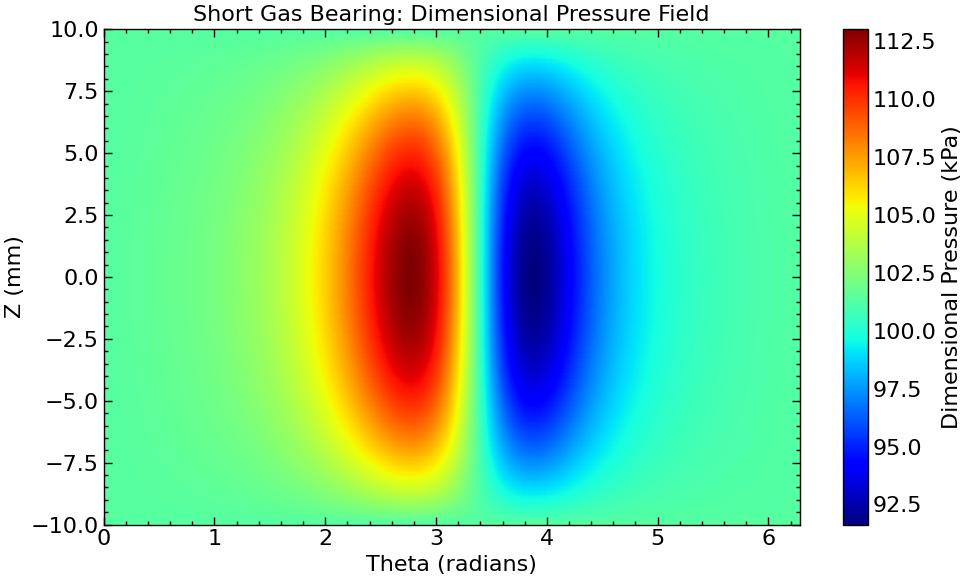

In [25]:
# Plot the dimensional pressure field for the short gas bearing in kPa using imshow
plt.figure(figsize=(10, 6))
plt.imshow(res['p_full'] / 1e3, extent=[0, 2 * np.pi, res['z'][0] * 1e3, res['z'][-1] * 1e3], aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Dimensional Pressure (kPa)')
plt.xlabel('Theta (radians)')
plt.ylabel('Z (mm)')
plt.title('Short Gas Bearing: Dimensional Pressure Field')
plt.tight_layout()
plt.grid(False)
plt.savefig('short_gas_bearing_pressure_field.png')  # Save the figure
plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# -------------------------------
# Short-bearing, compressible gas
# -------------------------------

@dataclass
class BearingParams:
    R: float        # journal radius [m]
    c: float        # radial clearance [m]
    mu: float       # viscosity [Pa·s]
    omega: float    # angular speed [rad/s]
    p_a: float      # ambient/supply pressure [Pa]
    eps: float      # eccentricity ratio 0<=eps<1
    L: float        # bearing length [m]

def H_fun(theta, eps):
    return 1.0 + eps * np.cos(theta)

def solve_short_bearing_gas(params: BearingParams,
                            ntheta=2048, nz=101,
                            tol=1e-12, maxit=60):
    """
    Short-bearing solution for isothermal gas:
      S(θ) = H P,  α = Λ L^2/(8 R^2),  Λ = 12 μ ω R^2 / (p_a c^2)
      dS/dθ = - (H/α) [S^2 - H^2]
      Reconstruct: P^2(θ, z) = 1 + (P_center^2 - 1) (1 - 4 z^2/L^2)
    Returns dictionary with pressure fields and diagnostics.
    """
    R, c, mu, omega, p_a, eps, L = params.R, params.c, params.mu, params.omega, params.p_a, params.eps, params.L
    if L <= 0:
        raise ValueError("L must be positive.")

    # Dimensionless numbers
    Lambda = 12.0 * mu * omega * R**2 / (p_a * c**2)
    alpha = Lambda * L**2 / (8.0 * R**2)

    theta = np.linspace(0, 2*np.pi, ntheta)
    dth = theta[1] - theta[0]
    H = H_fun(theta, eps)

    # ODE RHS: dS/dθ
    def rhs(th, Sval):
        Hloc = 1.0 + eps * np.cos(th)
        return -(Hloc/alpha) * (Sval**2 - Hloc**2)

    # RK4 integrator over θ
    def integrate_S(S0):
        S = np.empty_like(theta)
        S[0] = S0
        for i in range(ntheta-1):
            th = theta[i]
            s = S[i]
            k1 = rhs(th, s)
            k2 = rhs(th + 0.5*dth, s + 0.5*dth*k1)
            k3 = rhs(th + 0.5*dth, s + 0.5*dth*k2)
            k4 = rhs(th + dth,     s + dth*k3)
            S[i+1] = s + (dth/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return S

    # Shoot for periodic S(0) = S(2π)
    H0 = H[0]
    S0a, S0b = 0.9*H0, 1.1*H0
    Sa, Sb = integrate_S(S0a), integrate_S(S0b)
    Fa, Fb = Sa[-1] - S0a, Sb[-1] - S0b

    it = 0
    while abs(Fb) > tol and it < maxit:
        denom = (Fb - Fa)
        if abs(denom) < 1e-30:
            S0b += 1e-3
            Sb = integrate_S(S0b)
            Fb = Sb[-1] - S0b
            it += 1
            continue
        S0c = S0b - Fb * (S0b - S0a) / denom
        S0a, Fa = S0b, Fb
        S0b = S0c
        Sb = integrate_S(S0b)
        Fb = Sb[-1] - S0b
        it += 1

    S = Sb
    P_center = np.maximum(S / H, 1e-14)  # guard
    z = np.linspace(-L/2, L/2, nz)
    zfac = 1.0 - 4.0*(z[:, None]**2) / (L**2)
    P2_full = 1.0 + zfac * (P_center[None, :]**2 - 1.0)
    P2_full = np.maximum(P2_full, 1e-30)
    P_full = np.sqrt(P2_full)

    # A dimensionless “load” integral (area-integrated P)
    # W* ∝ ∫∫ P dθ dz; we exclude the trivial factor p_a and geometry
    Lstar = np.trapz(np.trapz(P_full, theta, axis=1), z)

    return {
        "theta": theta, "z": z,
        "H": H, "Lambda": Lambda, "alpha": alpha,
        "P_center": P_center,
        "P_full": P_full,        # shape (nz, ntheta)
        "P2_full": P2_full,      # shape (nz, ntheta)
        "shoot_iterations": it, "shoot_residual": abs(Fb),
        "Lstar": Lstar
    }

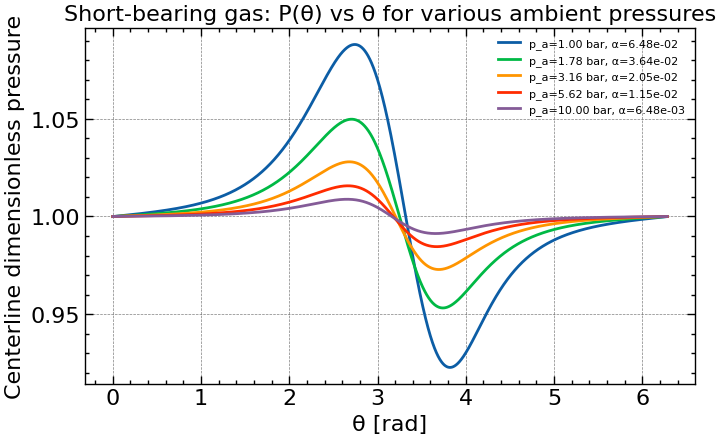

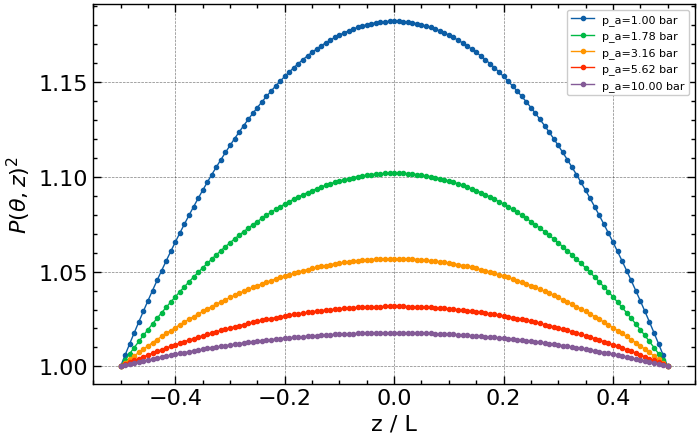

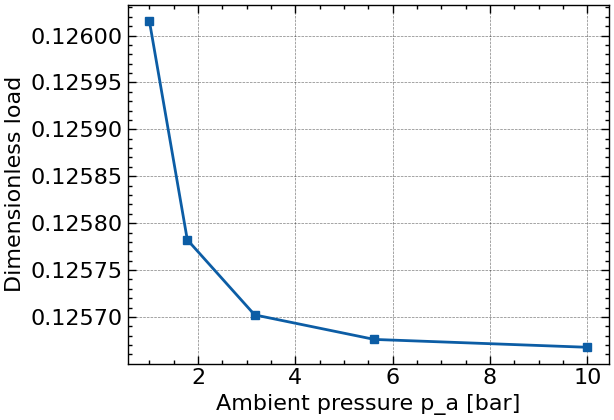

In [61]:
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
# -------------------------------
# Demo: compressibility effect
# -------------------------------

# Base parameters (air-like viscosity; geometry is illustrative)
R   = 0.05      # m
c   = 50e-6     # m
mu  = 1.8e-5    # Pa·s
omg = 1500.0    # rad/s
eps = 0.6       # eccentricity ratio
L   = 0.02      # m

# Sweep ambient pressure (controls compressibility through alpha ∝ 1/p_a)
# p_list = [0.3e5, 0.6e5, 1.0e5, 2.0e5, 4.0e5]  # Pa
p_list = np.logspace(5,6,5)

results = []
for p_a in p_list:
    params = BearingParams(R=R, c=c, mu=mu, omega=omg, p_a=p_a, eps=eps, L=L)
    res = solve_short_bearing_gas(params, ntheta=4096, nz=121)
    res["p_a"] = p_a
    results.append(res)

# Plot 1: Centerline pressure P(θ) vs θ for different p_a
plt.figure(figsize=(7.2, 4.6))
for res in results:
    th = res["theta"]; Pc = res["P_center"]
    lab = f"p_a={res['p_a']/1e5:.2f} bar, α={res['alpha']:.2e}"
    plt.plot(th, Pc, label=lab)
plt.xlabel("θ [rad]")
plt.ylabel("Centerline dimensionless pressure")
plt.title("Short-bearing gas: P(θ) vs θ for various ambient pressures")
plt.grid(True); plt.legend(fontsize=8,frameon=False)
plt.tight_layout()
plt.savefig('compressibility_Centerline dimensionless pressure.png')  # Save the figure

# Choose the case with mid p_a to identify θ at max P
res_mid = results[2]  # p_a ≈ 1 bar
th = res_mid["theta"]; Pc = res_mid["P_center"]
i_peak = np.argmax(Pc)
th_peak = th[i_peak]

# Plot 2: Demonstrate parabolic P^2 in z (compressible hallmark)
plt.figure(figsize=(7.2, 4.6))
z_norm = results[0]["z"] / L  # z normalized by L
for res in results:
    z = res["z"]
    # Extract P^2 at the same θ index for each case
    P2_at_peak = res["P2_full"][:, i_peak]
    plt.plot(z/L, P2_at_peak, marker='o', ms=3, lw=1.0,
                label=f"p_a={res['p_a']/1e5:.2f} bar")
plt.xlabel("z / L")
plt.ylabel(r"$P(\theta, z)^2$")
# plt.title("Compressible short-bearing: P^2 is parabolic in z")
plt.grid(True); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('compressibility_effect_parabolic_P2.png')  # Save the figure

# Plot 3: Dimensionless load vs ambient pressure
plt.figure(figsize=(6.2, 4.4))
p_bars = np.array([r["p_a"]/1e5 for r in results])
Lstar = np.array([r["Lstar"] for r in results])
plt.plot(p_bars, Lstar, marker='s')
plt.xlabel("Ambient pressure p_a [bar]")
plt.ylabel("Dimensionless load")
# plt.title("Effect of compressibility via p_a on dimensionless load")
plt.savefig('compressibility_effect_dimensionless_load.png')  # Save the figure
plt.grid(True); plt.tight_layout()

plt.show()

In [44]:
import matplotlib.pyplot as plt
from dataclasses import dataclass

# -------------------------------
# Short-bearing compressible gas solver (steady)
# -------------------------------

@dataclass
class BearingParams:
    R: float        # journal radius [m]
    c: float        # radial clearance [m]
    mu: float       # viscosity [Pa·s]
    omega: float    # journal angular speed [rad/s]
    p_a: float      # ambient pressure [Pa]
    eps: float      # eccentricity ratio, 0<=eps<1
    phi: float      # attitude angle (radians), 0 = minimum gap at theta=0; film thickness H = 1 + eps*cos(theta - phi)
    L: float        # bearing length [m]

def H_theta(theta, eps, phi):
    # Film thickness nondimensional: H = 1 + eps cos(θ - φ)
    return 1.0 + eps * np.cos(theta - phi)

def solve_short_bearing_gas(params: BearingParams,
                            ntheta=4096, nz=101,
                            tol=1e-12, maxit=60):
    """
    Steady short-bearing solution for isothermal compressible (gas) film.
    S(θ) = H P, α = Λ L^2 / (8 R^2), Λ = 12 μ ω R^2 / (p_a c^2)
    dS/dθ = - (H/α) [ S^2 - H^2 ]
    P^2(θ,z) = 1 + (P_center^2 - 1) (1 - 4 z^2/L^2)
    """
    R, c, mu, omega, p_a, eps, phi, L = params.R, params.c, params.mu, params.omega, params.p_a, params.eps, params.phi, params.L
    if L <= 0: raise ValueError("L must be positive.")
    if eps >= 1.0: raise ValueError("Eccentricity ratio must be < 1.")

    Lambda = 12.0 * mu * omega * R**2 / (p_a * c**2)
    alpha  = Lambda * L**2 / (8.0 * R**2)

    theta = np.linspace(0.0, 2.0*np.pi, ntheta)
    dth = theta[1] - theta[0]
    H = H_theta(theta, eps, phi)

    def rhs(th, Sval):
        Hloc = 1.0 + eps * np.cos(th - phi)
        return -(Hloc/alpha) * (Sval**2 - Hloc**2)

    def integrate_S(S0):
        S = np.empty_like(theta)
        S[0] = S0
        for i in range(ntheta-1):
            th = theta[i]; s = S[i]
            k1 = rhs(th, s)
            k2 = rhs(th + 0.5*dth, s + 0.5*dth*k1)
            k3 = rhs(th + 0.5*dth, s + 0.5*dth*k2)
            k4 = rhs(th + dth,     s + dth*k3)
            S[i+1] = s + (dth/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return S

    # shooting for periodic S
    H0 = 1.0 + eps * np.cos(0.0 - phi)
    S0a, S0b = 0.9*H0, 1.1*H0
    Sa, Sb = integrate_S(S0a), integrate_S(S0b)
    Fa, Fb = Sa[-1] - S0a, Sb[-1] - S0b

    it = 0
    while abs(Fb) > tol and it < maxit:
        denom = (Fb - Fa)
        if abs(denom) < 1e-30:
            S0b += 1e-3
            Sb = integrate_S(S0b); Fb = Sb[-1] - S0b; it += 1; continue
        S0c = S0b - Fb * (S0b - S0a) / denom
        S0a, Fa = S0b, Fb
        S0b = S0c
        Sb = integrate_S(S0b); Fb = Sb[-1] - S0b
        it += 1

    S = Sb
    P_center = np.maximum(S / H, 1e-14)
    z = np.linspace(-L/2, L/2, nz)
    zfac = 1.0 - 4.0*(z[:, None]**2) / (L**2)
    P2_full = 1.0 + zfac * (P_center[None, :]**2 - 1.0)
    P2_full = np.maximum(P2_full, 1e-30)
    P_full = np.sqrt(P2_full)
    p_full = P_full * p_a

    # Hydrodynamic forces (integrate pressure over surface)
    cos_th = np.cos(theta)[None, :]
    sin_th = np.sin(theta)[None, :]
    Wx = p_a * params.R * np.trapz(np.trapz(P_full * cos_th, theta, axis=1), z)  # N
    Wy = p_a * params.R * np.trapz(np.trapz(P_full * sin_th, theta, axis=1), z)  # N
    W = np.hypot(Wx, Wy)
    att = np.arctan2(Wy, Wx)

    return {
        "theta": theta, "z": z, "H": H,
        "Lambda": Lambda, "alpha": alpha,
        "S": S, "P_center": P_center,
        "P_full": P_full, "p_full": p_full,
        "Wx": Wx, "Wy": Wy, "W": W, "attitude_angle": att,
        "shoot_iterations": it, "shoot_residual": abs(Fb),
    }

# -------------------------------
# Static stiffness via finite differences
# -------------------------------
def stiffness_matrix(params: BearingParams, dxy=None, ntheta=4096):
    """
    Compute 2x2 stiffness K = dW/dx at the operating point using centered finite differences.
    x-axis aligned with θ=0 (cos θ), y-axis with θ=π/2 (sin θ).
    Displacements scaled by clearance c: ε and φ change as the journal center moves.
    """
    p = params
    if dxy is None:
        dxy = 0.02 * p.c  # 2% of clearance as small displacement

    # Helper to construct (eps, phi) from (x,y)
    # Journal center position relative to bush: x = ε c cosφ, y = ε c sinφ
    def eps_phi_from_xy(x, y):
        r = np.hypot(x, y)
        eps = r / p.c
        phi = np.arctan2(y, x)
        return eps, phi

    # Operating point (x0, y0) from eps, phi
    x0 = p.eps * p.c * np.cos(p.phi)
    y0 = p.eps * p.c * np.sin(p.phi)

    # Force at operating point
    base = solve_short_bearing_gas(p, ntheta=ntheta)
    Wx0, Wy0 = base["Wx"], base["Wy"]

    # Perturb in +x and -x (keep other params fixed)
    for_xp = BearingParams(p.R, p.c, p.mu, p.omega, p.p_a, *eps_phi_from_xy(x0 + dxy, y0), p.L)
    for_xm = BearingParams(p.R, p.c, p.mu, p.omega, p.p_a, *eps_phi_from_xy(x0 - dxy, y0), p.L)
    Wx_p = solve_short_bearing_gas(for_xp, ntheta=ntheta)["Wx"]
    Wy_p = solve_short_bearing_gas(for_xp, ntheta=ntheta)["Wy"]
    Wx_m = solve_short_bearing_gas(for_xm, ntheta=ntheta)["Wx"]
    Wy_m = solve_short_bearing_gas(for_xm, ntheta=ntheta)["Wy"]

    # Perturb in +y and -y
    for_yp = BearingParams(p.R, p.c, p.mu, p.omega, p.p_a, *eps_phi_from_xy(x0, y0 + dxy), p.L)
    for_ym = BearingParams(p.R, p.c, p.mu, p.omega, p.p_a, *eps_phi_from_xy(x0, y0 - dxy), p.L)
    Wx_py = solve_short_bearing_gas(for_yp, ntheta=ntheta)["Wx"]
    Wy_py = solve_short_bearing_gas(for_yp, ntheta=ntheta)["Wy"]
    Wx_my = solve_short_bearing_gas(for_ym, ntheta=ntheta)["Wx"]
    Wy_my = solve_short_bearing_gas(for_ym, ntheta=ntheta)["Wy"]

    dWdx = np.array([
        [(Wx_p - Wx_m) / (2*dxy), (Wx_py - Wx_my) / (2*dxy)],
        [(Wy_p - Wy_m) / (2*dxy), (Wy_py - Wy_my) / (2*dxy)]
    ])  # N/m

    return dWdx, {"Wx0": Wx0, "Wy0": Wy0, "x0": x0, "y0": y0, "dxy": dxy}

# -------------------------------
# Approximate damping from compressible squeeze (short-bearing)
# -------------------------------
def damping_matrix_squeeze(params: BearingParams, ntheta=4096, nz=81):
    """
    Estimate damping matrix due to compressible squeeze storage in the short-bearing limit.
    Returns a diagonal C (Cxx ≈ Cyy) in N·s/m. Cross-coupled terms ≈ 0 in this approximation.
    """
    p = params
    sol = solve_short_bearing_gas(p, ntheta=ntheta, nz=nz)
    theta = sol["theta"]             # (ntheta,)
    z = sol["z"]                     # (nz,)
    H_theta_1d = sol["H"]            # (ntheta,)

    # Broadcast H over z to get (nz, ntheta)
    H = np.broadcast_to(H_theta_1d[None, :], (len(z), len(theta)))
    h_local = p.c * H  # film thickness [m], shape (nz, ntheta)

    # Heuristic kernel capturing compressible squeeze trend ~ μ/(p_a h^3)
    # Units: scale to N·s/m using a 12 factor consistent with parallel plate squeeze
    kernel = (p.mu / p.p_a) * (p.R**2 / (h_local**3))  # shape (nz, ntheta)

    dtheta = theta[1] - theta[0]
    dz = z[1] - z[0] if len(z) > 1 else p.L

    # Integrate over surface. First integrate in θ (axis=1), then in z (axis=0).
    integ_theta = np.trapz(kernel, dx=dtheta, axis=1)    # (nz,)
    Kint = np.trapz(integ_theta, dx=dz, axis=0)          # scalar

    C0 = 12.0 * Kint  # N·s/m (approximate)
    C = np.array([[C0, 0.0],
                  [0.0, C0]])
    return C

def stiffness_matrix_star(params: BearingParams, dxy=None, ntheta=4096):
    """
    Dimensionless stiffness K* = K c / (p_a R L)
    """
    K, meta = stiffness_matrix(params, dxy=dxy, ntheta=ntheta)
    scale = params.c / (params.p_a * params.R * params.L)
    Kstar = K * scale
    return Kstar, meta

def damping_matrix_star(params: BearingParams, Omega=None, ntheta=4096, nz=81):
    """
    Dimensionless damping C* = (C Ω) / (p_a R L)
    Provide Omega [rad/s]. If None, uses params.omega (journal speed) as a default.
    """
    if Omega is None:
        Omega = params.omega
    C = damping_matrix_squeeze(params, ntheta=ntheta, nz=nz)
    scale = Omega / (params.p_a * params.R * params.L)
    Cstar = C * scale
    return Cstar

/var/folders/24/2v711qm121sdy7fprwc692100000gp/T/ipykernel_51895/774413648.py:45: RuntimeWarning: overflow encountered in scalar power
  return -(Hloc/alpha) * (Sval**2 - Hloc**2)
/var/folders/24/2v711qm121sdy7fprwc692100000gp/T/ipykernel_51895/774413648.py:67: RuntimeWarning: invalid value encountered in scalar subtract
  denom = (Fb - Fa)


p_a=0.30 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈4.508e-16 N·s/m
p_a=0.60 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈2.254e-16 N·s/m
p_a=0.60 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈2.254e-16 N·s/m
p_a=1.00 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈1.352e-16 N·s/m
p_a=1.00 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈1.352e-16 N·s/m
p_a=2.00 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈6.761e-17 N·s/m
p_a=2.00 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈6.761e-17 N·s/m
p_a=4.00 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈3.381e-17 N·s/m
p_a=4.00 bar: Kxx=nan N/m, Kxy=nan N/m, Kyx=nan N/m, Kyy=nan N/m | Cxx≈Cyy≈3.381e-17 N·s/m


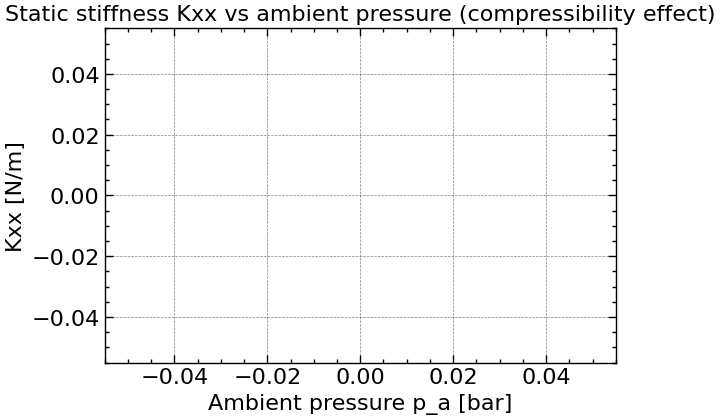

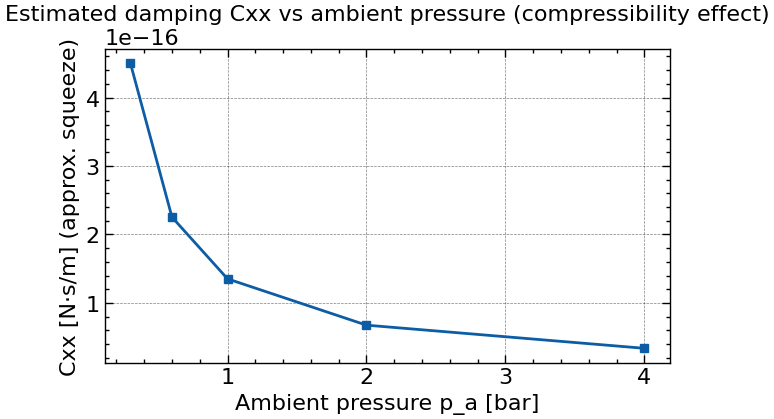

In [45]:
# Base parameters (air-like)
R   = 0.05      # m
c   = 50-6     # m
mu  = 1.8e-5    # Pa·s
omg = 1500.0 / 60 * 2*np.pi    # rad/s
L   = 0.02      # m

# Operating eccentricity and attitude (choose a loaded position)
eps = 0.8
phi = 0.0

# Sweep ambient pressure to show compressibility impact
p_list = [0.3e5, 0.6e5, 1.0e5, 2.0e5, 4.0e5]  # Pa

Kxx_list, Cxx_list = [], []
for p_a in p_list:
    bp = BearingParams(R=R, c=c, mu=mu, omega=omg, p_a=p_a, eps=eps, phi=phi, L=L)
    K, meta = stiffness_matrix(bp, dxy=0.02*c, ntheta=4096)
    C = damping_matrix_squeeze(bp, ntheta=2048, nz=81)
    Kxx_list.append(K[0,0]); Cxx_list.append(C[0,0])

    print(f"p_a={p_a/1e5:.2f} bar: Kxx={K[0,0]:.3e} N/m, Kxy={K[0,1]:.3e} N/m, "
            f"Kyx={K[1,0]:.3e} N/m, Kyy={K[1,1]:.3e} N/m | Cxx≈Cyy≈{C[0,0]:.3e} N·s/m")

# Plots
plt.figure(figsize=(6.4, 4.4))
plt.plot(np.array(p_list)/1e5, np.array(Kxx_list), marker='o')
plt.xlabel("Ambient pressure p_a [bar]")
plt.ylabel("Kxx [N/m]")
plt.title("Static stiffness Kxx vs ambient pressure (compressibility effect)")
plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6.4, 4.4))
plt.plot(np.array(p_list)/1e5, np.array(Cxx_list), marker='s')
plt.xlabel("Ambient pressure p_a [bar]")
plt.ylabel("Cxx [N·s/m] (approx. squeeze)")
plt.title("Estimated damping Cxx vs ambient pressure (compressibility effect)")
plt.grid(True); plt.tight_layout()

plt.show()

p_a=0.30 bar | Kxx=-6.692e+05 N/m, Kxx*=-1.115e+00 | Cxx≈6.516e+01 N·s/m, Cxx*≈3.258e+03
p_a=0.60 bar | Kxx=-5.554e+05 N/m, Kxx*=-4.629e-01 | Cxx≈3.258e+01 N·s/m, Cxx*≈8.145e+02
p_a=0.60 bar | Kxx=-5.554e+05 N/m, Kxx*=-4.629e-01 | Cxx≈3.258e+01 N·s/m, Cxx*≈8.145e+02
p_a=1.00 bar | Kxx=-4.182e+05 N/m, Kxx*=-2.091e-01 | Cxx≈1.955e+01 N·s/m, Cxx*≈2.932e+02
p_a=1.00 bar | Kxx=-4.182e+05 N/m, Kxx*=-2.091e-01 | Cxx≈1.955e+01 N·s/m, Cxx*≈2.932e+02
p_a=2.00 bar | Kxx=-2.435e+05 N/m, Kxx*=-6.088e-02 | Cxx≈9.775e+00 N·s/m, Cxx*≈7.331e+01
p_a=2.00 bar | Kxx=-2.435e+05 N/m, Kxx*=-6.088e-02 | Cxx≈9.775e+00 N·s/m, Cxx*≈7.331e+01
p_a=4.00 bar | Kxx=-1.283e+05 N/m, Kxx*=-1.603e-02 | Cxx≈4.887e+00 N·s/m, Cxx*≈1.833e+01
p_a=4.00 bar | Kxx=-1.283e+05 N/m, Kxx*=-1.603e-02 | Cxx≈4.887e+00 N·s/m, Cxx*≈1.833e+01


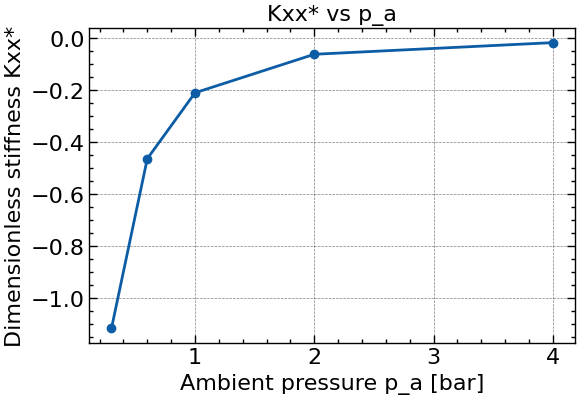

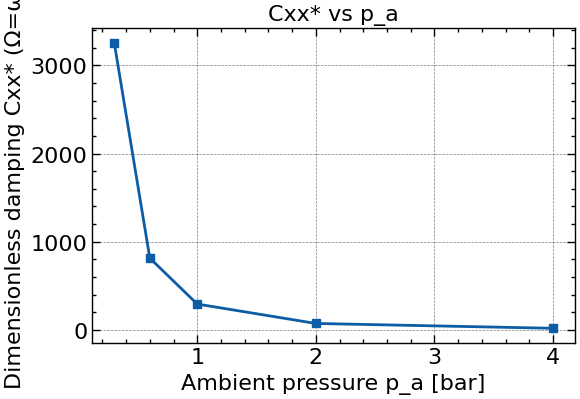

In [46]:
R   = 0.05
c   = 50e-6
mu  = 1.8e-5
omg = 1500.0
L   = 0.02
eps = 0.6
phi = 0.0

p_list = [0.3e5, 0.6e5, 1.0e5, 2.0e5, 4.0e5]

Kxx_list, Kxx_star_list, Cxx_list, Cxx_star_list = [], [], [], []
for p_a in p_list:
    bp = BearingParams(R=R, c=c, mu=mu, omega=omg, p_a=p_a, eps=eps, phi=phi, L=L)

    K, _ = stiffness_matrix(bp, dxy=0.02*c, ntheta=4096)
    Kstar, _ = stiffness_matrix_star(bp, dxy=0.02*c, ntheta=4096)

    C = damping_matrix_squeeze(bp, ntheta=2048, nz=81)
    Cstar = damping_matrix_star(bp, Omega=omg, ntheta=2048, nz=81)

    Kxx_list.append(K[0,0]); Kxx_star_list.append(Kstar[0,0])
    Cxx_list.append(C[0,0]); Cxx_star_list.append(Cstar[0,0])

    print(
        f"p_a={p_a/1e5:.2f} bar | "
        f"Kxx={K[0,0]:.3e} N/m, Kxx*={Kstar[0,0]:.3e} | "
        f"Cxx≈{C[0,0]:.3e} N·s/m, Cxx*≈{Cstar[0,0]:.3e}"
    )

# Optional plots of dimensionless coefficients
import matplotlib.pyplot as plt
xbar = np.array(p_list)/1e5
plt.figure(figsize=(6.0,4.2))
plt.plot(xbar, Kxx_star_list, marker='o')
plt.xlabel("Ambient pressure p_a [bar]")
plt.ylabel("Dimensionless stiffness Kxx*")
plt.title("Kxx* vs p_a")
plt.grid(True); plt.tight_layout()

plt.figure(figsize=(6.0,4.2))
plt.plot(xbar, Cxx_star_list, marker='s')
plt.xlabel("Ambient pressure p_a [bar]")
plt.ylabel("Dimensionless damping Cxx* (Ω=ω)")
plt.title("Cxx* vs p_a")
plt.grid(True); plt.tight_layout()
plt.show()